# **Прогнозирование цен на золото с использованием модели LSTM**

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Загрузка данных о цене золота

In [39]:
data = pd.read_csv('Gold_Price.csv')
data

,Date,Close,Open,High,Low,Volume,Chg%
0,2014-01-01,29542,29435,29598,29340,2930,0.25
1,2014-01-02,29975,29678,30050,29678,3140,1.47
2,2014-01-03,29727,30031,30125,29539,3050,-0.83
3,2014-01-04,29279,29279,29279,29279,0,-1.51
4,2014-01-06,29119,29300,29395,29051,24380,-0.55
...,...,...,...,...,...,...,...
2222,2022-08-01,51260,51899,51899,51023,1350,-0.20
2223,2022-08-02,51274,51438,51527,51100,230,0.03
2224,2022-08-03,51225,51250,51375,51137,70,-0.10
2225,2022-08-04,51802,51713,51903,51713,10,1.13


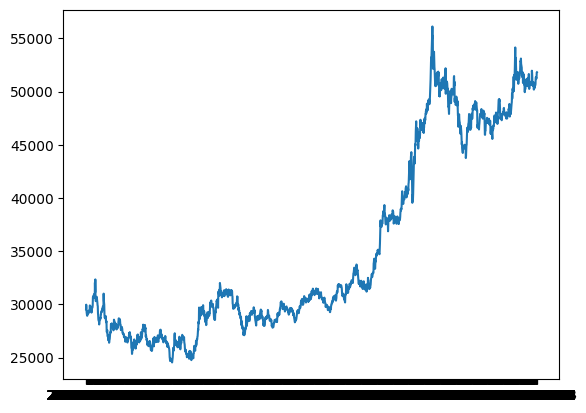

In [40]:
newdate = data["Date"]
newdate
newclose = data["Close"]
newdate
plt.plot(newdate,newclose)

Нормализация данных

In [41]:
prices = data['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
prices_normalized = scaler.fit_transform(prices)

Создание последовательностей для прогнозирования временных рядов

In [42]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []

    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

# Установка длины последовательности
sequence_length = 20

# Создание последовательностей и целевых значений
X, y = create_sequences(prices_normalized, sequence_length)

Разделение данных на тренировочный и тестовый наборы

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
print(X_train.shape) , print(X_test.shape) , print(y_train.shape) , print(y_test.shape)

(1324, 20, 1)
(883, 20, 1)
(1324, 1)
(883, 1)


(None, None, None, None)

**Построение модели SimpleRNN**

In [44]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Выбор оптимизатора с дополнительными параметрами
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Компиляция модели
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 20, 100)           40800     
                                                                 
 dropout_42 (Dropout)        (None, 20, 100)           0         
                                                                 
 lstm_41 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_43 (Dropout)        (None, 100)               0         
                                                                 
 dense_42 (Dense)            (None, 50)                5050      
                                                                 
 dense_43 (Dense)            (None, 1)                 51        
                                                                 
Total params: 126301 (493.36 KB)
Trainable params: 12

Обучение модели с использованием валидационных данных

In [45]:
# Реализация ранней остановки
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
print("Обучение модели...")
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

Обучение модели...
Epoch 1/50
42/42 [==============================] - 6s 50ms/step - loss: 0.0408 - val_loss: 0.0034
Epoch 2/50
42/42 [==============================] - 2s 42ms/step - loss: 0.0036 - val_loss: 7.7284e-04
Epoch 3/50
42/42 [==============================] - 2s 42ms/step - loss: 0.0022 - val_loss: 7.0055e-04
Epoch 4/50
42/42 [==============================] - 2s 41ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 5/50
42/42 [==============================] - 2s 42ms/step - loss: 0.0018 - val_loss: 6.6739e-04
Epoch 6/50
42/42 [==============================] - 3s 66ms/step - loss: 0.0018 - val_loss: 6.2316e-04
Epoch 7/50
42/42 [==============================] - 2s 59ms/step - loss: 0.0016 - val_loss: 6.8246e-04
Epoch 8/50
42/42 [==============================] - 2s 42ms/step - loss: 0.0018 - val_loss: 5.9794e-04
Epoch 9/50
42/42 [==============================] - 2s 44ms/step - loss: 0.0016 - val_loss: 5.6024e-04
Epoch 10/50
42/42 [==============================] - 2s 41ms/s

Вывод графика функции потерь

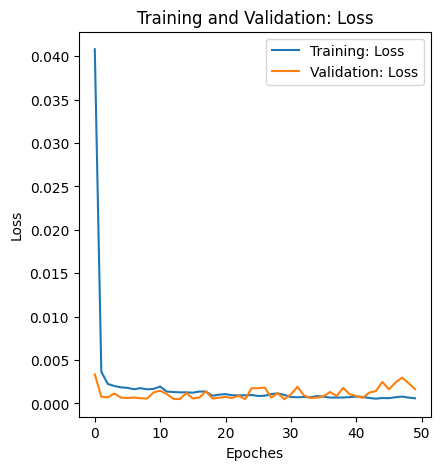

In [46]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training: Loss')
plt.plot(history.history['val_loss'], label='Validation: Loss')
plt.title('Training and Validation: Loss')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [47]:
# Прогнозирование на существующих данных
print("Прогнозирование на существующих данных...")
predictions_normalized = model.predict(X)
predictions = scaler.inverse_transform(predictions_normalized)

Прогнозирование на существующих данных...
69/69 [==============================] - 2s 16ms/step


Вывод графика фактических цен и прогнозов

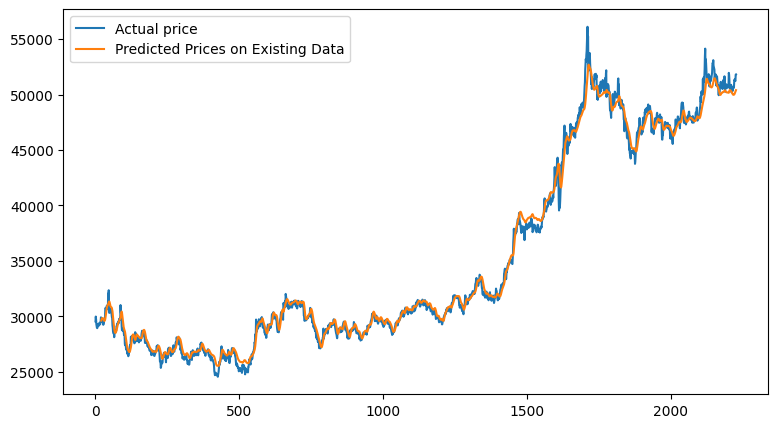

In [48]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(prices, label='Actual price')
plt.plot(range(sequence_length, len(prices)), predictions, label='Predicted Prices on Existing Data')
plt.legend()
plt.show()

Прогнозирование в будущем

In [49]:
future_periods = 48
future_predictions = []

# Использование последовательности из последних тренировочных данных для начала прогнозирования
current_sequence = X[-1]

print("Прогнозирование в будущем...")
for _ in range(future_periods):
    # Изменение формы последовательности, чтобы соответствовать форме входных данных модели
    current_sequence = current_sequence.reshape(1, sequence_length, 1)

    # Прогноз следующей цены
    next_price_normalized = model.predict(current_sequence)[0, 0]

    # Добавление прогнозируемой цены в будущее
    future_predictions.append(next_price_normalized)

    # Обновление текущей последовательности для следующей итерации
    current_sequence = np.roll(current_sequence, -1, axis=1)
    current_sequence[0, -1, 0] = next_price_normalized

# Инверсия преобразования для получения фактических цен
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

Прогнозирование в будущем...
1/1 [==============================] - 0s 26ms/step


Вывод графика фактических цен, прогнозов и прогнозов в будущем

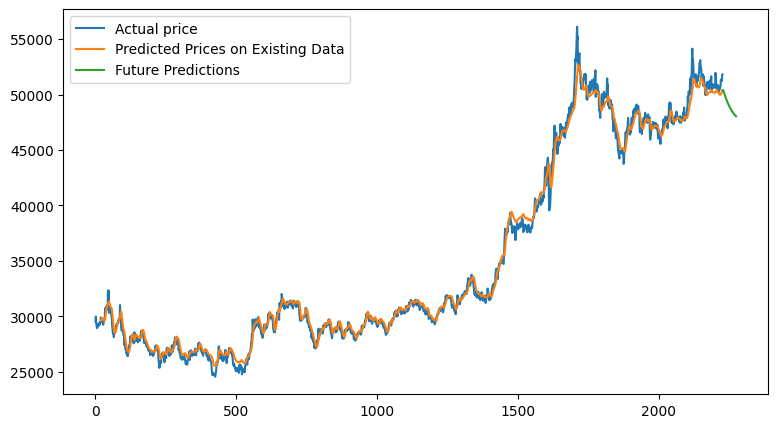

In [50]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
plt.plot(prices, label='Actual price')
plt.plot(range(sequence_length, len(prices)), predictions, label='Predicted Prices on Existing Data')
plt.plot(range(len(prices), len(prices) + len(future_predictions)), future_predictions, label='Future Predictions')
plt.legend()
plt.show()